# Task Generation

## Imports

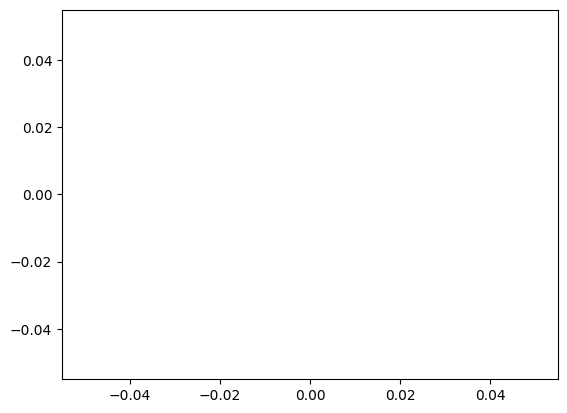

In [1]:
import matplotlib.pyplot as plt

plt.plot()
plt.show()

In [3]:
import numpy as np
import random
from scipy.stats import beta
import spacy
from spacy import displacy 
from tqdm import tqdm # For progress bar
import copy
import os
import math

In [4]:
nlp = spacy.load("en_core_web_sm")
import pickle

In [5]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

In [6]:
from ultralytics import YOLO

In [7]:
from PIL import Image

In [8]:
model = YOLO("yolov8l.pt")#YOLO("yolov8m.pt")

## Initialize the map

In [9]:
grid_height = 5
grid_width = 10
num_steps = 10
num_landmarks = 4

In [10]:
# Path images
directory_path = "./Icons/yolo8/"
# Get a list of image files in the directory
image_files = [os.path.join(directory_path, filename) for filename in os.listdir(directory_path)]

In [11]:
# Randomly set landmarks and road
def initialize_landmark_loc(grid_width, grid_height, num_landmarks, distance=2, max_attempts=1000):
    locations = []    
    for _ in range(num_landmarks):
        for attempt in range(max_attempts):
            new_loc = [random.randint(1, grid_width-2), random.randint(1, grid_height-1)]
            if all(abs(loc[0]-new_loc[0])>=distance or abs(loc[1]-new_loc[1])>=distance for loc in locations):
                break
            
            # if max attempts reached append location regardless of distance
            if attempt == max_attempts - 1:
                print(f"Couldn't find a suitable location for the point after {max_attempts} attempts. Ignoring distance constraint.")
        locations.append(new_loc)
    return locations

In [12]:
def create_grid_map(images, locations, road, grid_width, grid_height, save=False):
    # Create the figure
    fig, ax = plt.subplots(figsize=(555 / 80, 330 / 80))

    # Draw the grid lines
    major_ticks = np.arange(0, max(grid_width, grid_height), 1)
    ax.set_xticks(major_ticks)
    ax.set_yticks(major_ticks)
    ax.grid(which='both')
    # Remove axis labels
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # For each image and location, add to the plot
    for image, location in zip(images, locations):
        # Open the image
        img = Image.open(image)
        
        # Convert the image into numpy array
        img = np.array(img).astype(np.uint8) / 255.
        
        # Create an offset image artist
        im = OffsetImage(img, zoom=0.45)
        
        # Use AnnotationBbox to put the image on the plot at the specified location
        ab = AnnotationBbox(im, location, frameon=False)

        # Add the artist to the plot
        ax.add_artist(ab)
    
    # Set the limits of the plot to the limits of the grid
    ax.set_xlim(-1, grid_width)
    ax.set_ylim(-1, grid_height)
    
    if save:
        plt.savefig('map.png', dpi=80, bbox_inches='tight')
        
    # Render the road as lines on the grid
    for i in range(1, len(road)):
        line = Line2D((road[i-1][0], road[i][0]), (road[i-1][1], road[i][1]), linewidth=30, color='grey')
        ax.add_line(line)
    
    # Add a red Rectangle artist covering the valid area.
    rectangle = Rectangle((0, 0), grid_width-1, grid_height-1, facecolor='green', alpha=0.1)
    ax.add_patch(rectangle)
        
    # Add a star at the end of the road
    ax.scatter(road[-1][0], road[-1][1], marker='*', color='yellow', s=500, zorder=4)
    # Add a circle at the start of the road
    ax.scatter(road[0][0], road[0][1], marker='o', color='yellow', s=400, zorder=4)

    # Apply a tight layout
    plt.tight_layout()
    
    
    # Return the figure and axes
    return fig, ax

# Usage of the function
# map_fig, map_ax = create_grid_map(images, locations, road, grid_width, grid_height)

In [13]:
def random_road(car_init, num_steps, grid_width, grid_height):
    # initialize the path with the car's initial position
    road = [car_init[0]]
    
    for _ in range(num_steps):
        # get the last position
        last_position = road[-1]
        
        # generate possible moves
        possible_moves = []
        if last_position[0] < grid_width - 1:  #if not on the right edge
            possible_moves.append([last_position[0] + 1, last_position[1]])
        
        if last_position[1] < grid_height - 1:  #if not on the upper edge
            possible_moves.append([last_position[0], last_position[1] + 1])
        
        # if there are possible moves, randomly choose one
        if possible_moves:
            new_position = possible_moves[np.random.randint(0, len(possible_moves))]
            road.append(new_position)
        else:
            break   #if stuck (at upper-right corner), then end the loop early
    
    return np.array(road)

In [14]:
def add_trajectory(map_fig, map_ax, trajectory, start, color='blue', linestyle='-'):
    print(trajectory)
    line = Line2D((start[0],trajectory[0][0]),
                  (start[1], trajectory[0][1]), linewidth=2, color=color, linestyle=linestyle)
    map_ax.add_line(line)
    for i in range(1, len(trajectory)):
        line = Line2D((trajectory[i-1][0], trajectory[i][0]),
                      (trajectory[i-1][1], trajectory[i][1]), linewidth=2, color=color, linestyle=linestyle, zorder = 4)
        map_ax.add_line(line)
        
    # Create a square at the end of the trajectory
    s = 0.25 # Size of the square
    square = Rectangle((trajectory[-1][0]-s/2, trajectory[-1][1]-s/2), s, s, color=color, alpha=0.5, zorder = 5)
    map_ax.add_patch(square)
    map_fig.canvas.draw()
    #plt.show()
    
#add_trajectory(map_fig, map_ax, trajectory, locations[0])
#plt.show() # Now the map in the figure above should have the added red trajectory on it

In [15]:
def map_reward_estimation(state_expected_reward, state_uncertainty):
    fig, ax = plt.subplots(figsize=(555 / 80, 330 / 80))
    cmap = plt.cm.RdYlGn
     # Render the road as lines on the grid
    for i in range(1, len(road)):
        line = Line2D((road[i-1][0], road[i][0]), (road[i-1][1], road[i][1]), linewidth=30, color='grey')
        ax.add_line(line)
     # For each image and location, add to the plot
    for image, location in zip(images, loc_landmarks):
        # Open the image
        img = Image.open(image)
        # Convert the image into numpy array
        img = np.array(img).astype(np.uint8) / 255.
        # Create an offset image artist
        im = OffsetImage(img, zoom=0.3)
        # Use AnnotationBbox to put the image on the plot at the specified location
        ab = AnnotationBbox(im, location, frameon=False)
        # Add the artist to the plot
        ax.add_artist(ab)
    for ii in range(state_expected_reward.size):
        grid_row = ii // grid_height
        grid_col = ii % grid_height
        size = 500 * state_uncertainty[ii]  # scale factor for visibility of circles
        sc = ax.scatter(grid_row, grid_col,  s=size, c=[[state_expected_reward[ii]]], vmin=-1, vmax=1, cmap=cmap, zorder = 3)
    # Plot reward as color and uncertainty as size of the ball
    plt.colorbar(sc, cmap=cmap, ax=ax)
    plt.title('Expected Reward Map')
    major_ticks = np.arange(0, max(grid_width, grid_height), 1)
    ax.set_xticks(np.arange(-1,grid_width+1))
    ax.set_yticks(np.arange(-1,grid_height+1))
    ax.grid(which='both')
    # Remove axis labels
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.show()

In [16]:
class GridEnvironment:
    def __init__(self, grid_width, grid_height, num_steps, start):
        self.grid_width = grid_width
        self.grid_height = grid_height
        self.num_steps = num_steps # Number of steps per trajectory
        # Define the starting position
        self.start = start
        self.current_position = start

    # Function to reset the environment and start a new episode
    def reset(self):
        self.current_position = self.start
        return self.current_position

    # Function to take an action
    def step(self, action):
        x, y = self.current_position
        # action 0 means move up
        if action == 0 and y < grid_height - 1:
            y += 1
        # action 1 means move right
        elif action == 1 and x < grid_width - 1:
            x += 1
        # new state
        self.current_position = (x, y)

        return self.current_position

## Experiments

In [17]:
car_init = [[0, 0]]
loc_landmarks = initialize_landmark_loc(grid_width, grid_height, num_landmarks, 1) # Coordinates of landmarks
images = random.sample(image_files, num_landmarks) # Select randomly among images to add to the map
locations = car_init + loc_landmarks # Coordinates for starting point of car + landmarks
road = random_road(car_init, num_steps, grid_width, grid_height) # The road is the ideal path to be completed in num_steps

(<Figure size 693.75x412.5 with 1 Axes>, <AxesSubplot:>)

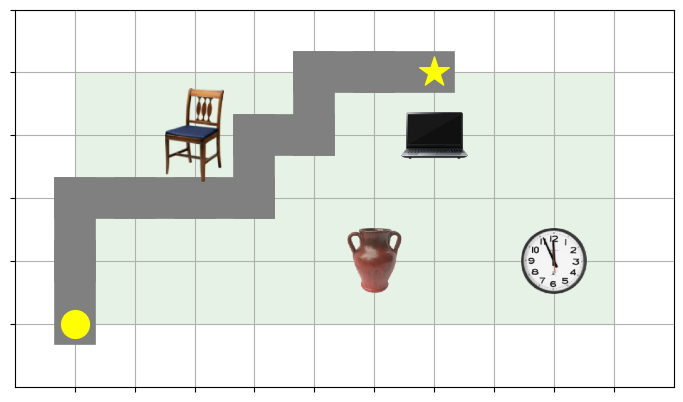

In [18]:
create_grid_map(images, loc_landmarks, road, grid_width, grid_height, save=True)

In [ ]:
# Locate Landmarks
results = model.predict("map.png")
result = results[0]
list_landmarks = []
pixel_landmarks = np.zeros([len(result.boxes), 4])
count = 0
# Get the grid-square size in pixels
image = Image.open('map.png')
square_size_y = image.height / (grid_height + 1)
square_size_x = image.width / (grid_width + 1)
for box in result.boxes:
    class_id = result.names[box.cls[0].item()]
    list_landmarks.append(nlp(class_id))
    cords = box.xyxy[0].tolist()
    pixel_landmarks[count, 0] = max(math.floor(cords[0]/square_size_x - 1), 0)
    pixel_landmarks[count, 1] = min(math.ceil(cords[2]/square_size_x - 1), grid_width - 1)
    pixel_landmarks[count, 2] = max(math.floor(grid_height - cords[3]/square_size_y), 0)
    pixel_landmarks[count, 3] = min(math.ceil(grid_height - cords[1]/square_size_y), grid_height-1)
    # conf = round(box.conf[0].item(), 2) # Probability of correct identification
    count += 1
print(list_landmarks)
print(pixel_landmarks)

In [21]:
data_to_save = [images, loc_landmarks, road, pixel_landmarks, list_landmarks]

In [ ]:
# Filename to save the data
filename = "exp_init10.pkl"

# Save the data
with open(filename, "wb") as file:
    pickle.dump(data_to_save, file)

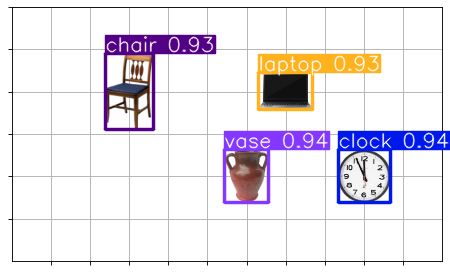

In [22]:
Image.fromarray(result.plot()[:,:,::-1])